In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot, mask
from rasterstats import zonal_stats
import xarray
import numpy as np
from dateutil import parser
import os

# This script examines the relationship between landslide reactivation and NDVI

This script almost entirely authored by Alan, with the last couple cells added by Paul

In [15]:
# import landslide polygons
shapefile_shx = "../0-brute-raw-data/Landslides.shx"
shapefile_shx ="/home/jovyan/nz-landslides/0-brute-raw-data/polygon/landslides_inventory.gpkg"
shapefile_meandiff='/home/jovyan/nz-landslides/2-processed data/polygon/inventory_mean_diff.gpkg'
nz_landslide_polygons = gpd.read_file(shapefile_shx)
nz_meandiff_polygons= gpd.read_file(shapefile_meandiff)
nz_landslide_polygons = nz_meandiff_polygons

<Axes: >

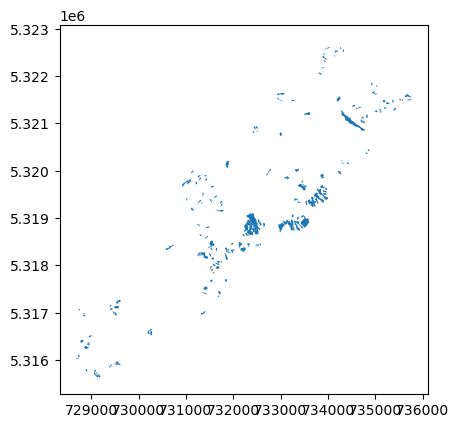

In [17]:
#plot to make sure they're there
%matplotlib inline
nz_landslide_polygons.plot()

# import ndvi tiff and Match crs

In [21]:
#The ndvi .tiff file was created from landsat download ndvi script

#img_folder = "/home/jovyan/nz-landslides/1-raw-data/ndvi/"
#test_fn = "LC08_L2SP_073089_20161215_20200905_02_T1_ndvi"
#test_src = rio.open(img_folder + test_fn+".TIF")
img_fn='/home/jovyan/not-nz-landslides/LC08_L2SP_073089_20161215_20200905_02_T1_ndvi.tiff'
test_src = rio.open(img_fn)

ndvi_crs = test_src.crs
ndvi_crs

CRS.from_epsg(32659)

In [1]:
#nz_landslide_polygons.crs

In [3]:
nz_landslide_reprojected = nz_landslide_polygons.to_crs(ndvi_crs)
nz_landslide_reprojected.crs

NameError: name 'nz_landslide_polygons' is not defined

In [24]:
#read the image to a numpy arr
r= test_src.read(1, masked = True)

<Axes: >

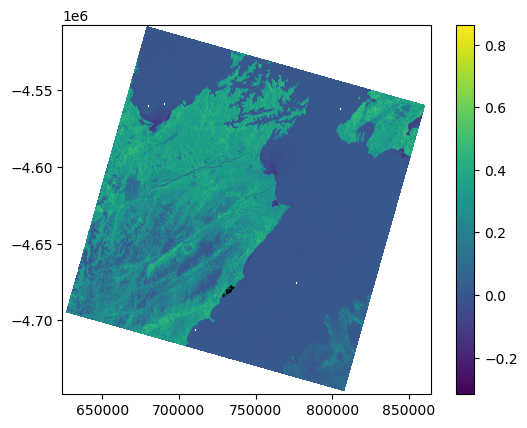

In [25]:
# plot an overview fig.
ndvi_extent = rio.plot.plotting_extent(test_src)

f, ax = plt.subplots()
a = ax.imshow(r, extent=ndvi_extent)
f.colorbar(a)
nz_landslide_reprojected.plot(ax=ax, facecolor='y', edgecolor='k')

In [26]:
test_src.nodata

999.9000244140625

# Find NDVI statistics for each polygon

In [27]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
nz_ma, nz_ma_transform = rio.mask.mask(test_src, nz_landslide_reprojected.geometry, **rio_mask_kwargs)
nz_ma_extent = rio.plot.plotting_extent(nz_ma, nz_ma_transform)

In [28]:
mean_above_zero = lambda l: l[l>0].mean()
count_above_zero = lambda l: np.count_nonzero(l[l>0])


In [29]:
stats = ['count', 'mean']
zonalstats = zonal_stats(nz_landslide_reprojected, raster=r, affine=test_src.transform,nodata=test_src.nodata,
            stats=stats)
zonalstats


[{'mean': 0.2876976728439331, 'count': 2},
 {'mean': 0.21054290235042572, 'count': 1},
 {'mean': 0.15338033437728882, 'count': 2},
 {'mean': 0.11543259024620056, 'count': 2},
 {'mean': 0.11738546937704086, 'count': 1},
 {'count': 0, 'mean': None},
 {'mean': 0.27783575654029846, 'count': 2},
 {'mean': 0.2578543424606323, 'count': 2},
 {'mean': 0.23644647002220154, 'count': 2},
 {'mean': 0.23553119599819183, 'count': 1},
 {'mean': 0.1772129237651825, 'count': 2},
 {'mean': 0.16864959398905435, 'count': 3},
 {'count': 0, 'mean': None},
 {'mean': 0.22170525789260864, 'count': 2},
 {'mean': 0.21127314865589142, 'count': 2},
 {'mean': 0.2386840581893921, 'count': 3},
 {'mean': 0.3037945628166199, 'count': 2},
 {'mean': 0.25261756777763367, 'count': 1},
 {'mean': 0.22229441006978354, 'count': 3},
 {'mean': 0.2390199452638626, 'count': 2},
 {'mean': 0.17831090092658997, 'count': 4},
 {'mean': 0.3297674357891083, 'count': 1},
 {'mean': 0.28152283032735187, 'count': 3},
 {'count': 0, 'mean': Non

In [30]:
nz_landslide_reprojected.head()

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,mean_diff,geometry
0,13412,0,147.985920,1348.158784,1348.158784,None,None,0.106602,"POLYGON ((728916.504 -4684243.222, 728915.663 ..."
1,13473,0,80.741391,407.936149,407.936149,None,None,0.026058,"POLYGON ((728705.038 -4683984.377, 728704.600 ..."
2,13465,0,158.667128,1675.133073,1675.133073,None,None,-1.576621,"POLYGON ((729182.519 -4684364.976, 729181.302 ..."
3,13466,0,177.412938,1572.323108,1572.323108,None,None,-0.842994,"POLYGON ((729136.188 -4684358.835, 729134.479 ..."
4,13467,0,134.624908,727.482580,727.482580,None,None,-0.907851,"POLYGON ((729119.932 -4684347.751, 729118.900 ..."


In [35]:
zonal_df = pd.DataFrame(zonalstats, columns = ['ndvipixelcount', 'mean_ndvi'])
nz_landslide_reprojected = nz_landslide_reprojected.join(zonal_df)

In [36]:
zonal_df.to_csv("../2-processed data/ndvi/" + test_fn + ".csv")

In [ ]:
#%matplotlib widget

In [37]:
nz_landslide_reprojected['mean'].min()

0.07888374141618318

<Axes: >

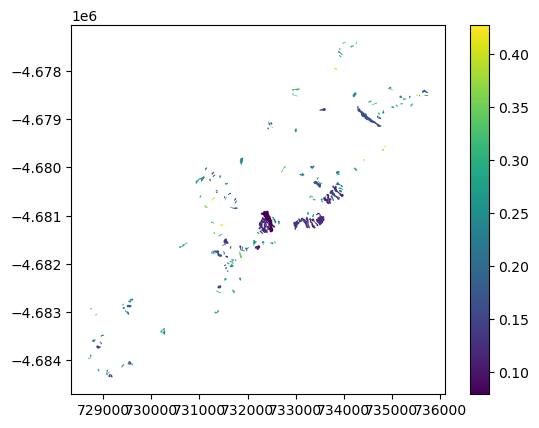

In [33]:
nz_landslide_reprojected.plot('mean', legend=True)

In [38]:
# now we have our ndvi pixel count as count and value as mean in the slides gdf

nz_landslide_reprojected.head()


,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,mean_diff,geometry,count,mean,ndvipixelcount,mean_ndvi
0,13412,0,147.985920,1348.158784,1348.158784,None,None,0.106602,"POLYGON ((728916.504 -4684243.222, 728915.663 ...",2,0.287698,NaN,NaN
1,13473,0,80.741391,407.936149,407.936149,None,None,0.026058,"POLYGON ((728705.038 -4683984.377, 728704.600 ...",1,0.210543,NaN,NaN
2,13465,0,158.667128,1675.133073,1675.133073,None,None,-1.576621,"POLYGON ((729182.519 -4684364.976, 729181.302 ...",2,0.153380,NaN,NaN
3,13466,0,177.412938,1572.323108,1572.323108,None,None,-0.842994,"POLYGON ((729136.188 -4684358.835, 729134.479 ...",2,0.115433,NaN,NaN
4,13467,0,134.624908,727.482580,727.482580,None,None,-0.907851,"POLYGON ((729119.932 -4684347.751, 729118.900 ...",1,0.117385,NaN,NaN


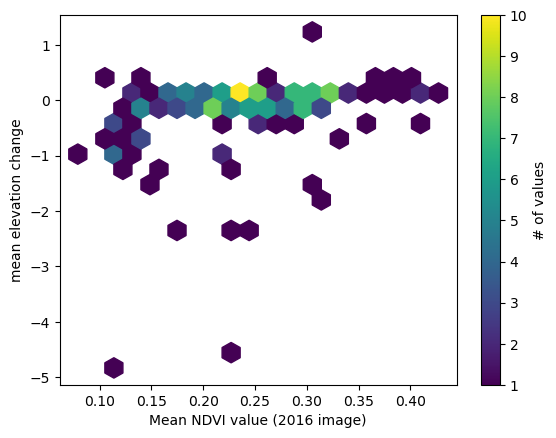

In [41]:
#visualize the ndvi and landslide dem difference displacement values

fig, ax1 = plt.subplots()
hex=ax1.hexbin(x = nz_landslide_reprojected['mean'], y = nz_landslide_reprojected.mean_diff,gridsize = 20,mincnt=1)
#ax1.set_aspect('equal')
#ax1.set(xlim=(0, 8), ylim=(0, 8))
ax1.set(xlabel=('Mean NDVI value (2016 image)'), ylabel=('mean elevation change'))


#plt.plot(oneonelinex,oneoneliney,'r--')
cbar=fig.colorbar(hex)
cbar.set_label('# of values')

plt.show()

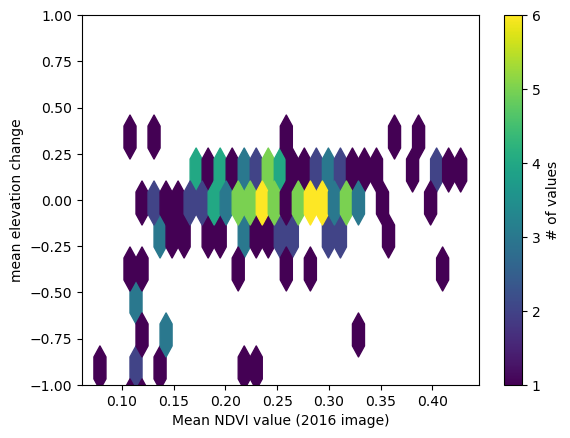

In [45]:
fig, ax1 = plt.subplots()
hex=ax1.hexbin(x = nz_landslide_reprojected['mean'], y = nz_landslide_reprojected.mean_diff,gridsize = 30,mincnt=1)
#ax1.set_aspect('equal')
ax1.set(ylim=(-1, 1))
ax1.set(xlabel=('Mean NDVI value (2016 image)'), ylabel=('mean elevation change'))


#plt.plot(oneonelinex,oneoneliney,'r--')
cbar=fig.colorbar(hex)
cbar.set_label('# of values')

plt.show()

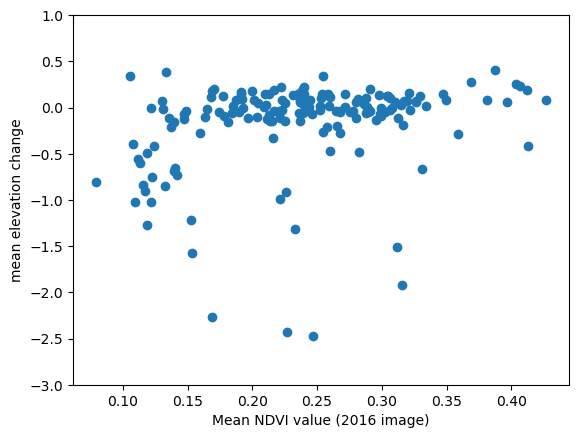

In [48]:
fig, ax1 = plt.subplots()
#hex=ax1.hexbin(x = nz_landslide_reprojected['mean'], y = nz_landslide_reprojected.mean_diff,gridsize = 30,mincnt=1)
plt.scatter(nz_landslide_reprojected['mean'],nz_landslide_reprojected['mean_diff'])
#ax1.set_aspect('equal')
ax1.set(ylim=(-3, 1))
ax1.set(xlabel=('Mean NDVI value (2016 image)'), ylabel=('mean elevation change'))


#plt.plot(oneonelinex,oneoneliney,'r--')
cbar=fig.colorbar(hex)
cbar.set_label('# of values')

plt.show()

In [40]:
nz_landslide_reprojected.mean

<bound method DataFrame.mean of      OBJECTID  LD  Shape_Leng   Shape_Area         area  xLoc  yLoc  \
0       13412   0  147.985920  1348.158784  1348.158784  None  None   
1       13473   0   80.741391   407.936149   407.936149  None  None   
2       13465   0  158.667128  1675.133073  1675.133073  None  None   
3       13466   0  177.412938  1572.323108  1572.323108  None  None   
4       13467   0  134.624908   727.482580   727.482580  None  None   
..        ...  ..         ...          ...          ...   ...   ...   
184     13438   0  156.068436  1622.320714  1622.320714  None  None   
185     13445   0  100.652992   685.693822   685.693822  None  None   
186      2722   0  197.419449  1154.965575  1154.965575  None  None   
187      2721   0  377.408441  4461.728613  4461.728613  None  None   
188      2731   0  146.577716  1339.632541  1339.632541  None  None   

     mean_diff                                           geometry  count  \
0     0.106602  POLYGON ((728916.504 -4

# Calculate stats for each time

In [75]:
images = []

for input in ['img_list.txt', 'autoselected_images.txt']:
    with open(img_folder + input) as f:
        for l in f:
            id = l.split(',')[1]
            if os.path.exists(img_folder + id + "_ndvi.TIF"):
                images.append(id)
            elif os.path.exists(img_folder + id[:-1] + "_ndvi.TIF"):
                images.append(id[:-1])

images

['LC08_L2SP_073089_20161215_20200905_02_T1',
 'LC08_L2SP_073089_20160419_20200907_02_T1',
 'LC08_L2SP_073089_20161012_20200905_02_T1',
 'LC08_L2SP_073089_20161215_20200905_02_T1',
 'LC08_L2SP_073089_20171202_20200902_02_T1',
 'LC08_L2SP_073089_20181018_20200830_02_T1',
 'LC08_L2SP_073089_20201210_20210313_02_T1',
 'LC09_L2SP_073089_20221122_20230321_02_T1',
 'LC08_L2SP_073089_20231219_20240103_02_T1',
 'LE07_L2SP_074089_20231210_20240105_02_T1',
 'LC09_L2SP_073089_20231125_20231128_02_T1',
 'LC08_L2SP_073089_20221114_20221122_02_T1',
 'LC09_L2SP_073089_20221106_20221110_02_T1',
 'LE07_L2SP_073089_20221104_20221130_02_T1',
 'LE07_L2SP_073089_20201202_20201229_02_T1',
 'LC08_L2SP_073089_20201023_20201105_02_T1',
 'LC08_L2SP_073089_20191208_20200824_02_T1',
 'LC08_L2SP_073089_20191005_20200825_02_T1',
 'LC08_L2SP_073089_20181018_20200830_02_T1',
 'LC08_L2SP_073089_20171202_20200902_02_T1',
 'LC08_L2SP_073089_20161215_20200905_02_T1',
 'LC08_L2SP_073089_20161012_20200905_02_T1',
 'LC08_L2S

In [78]:
def clip_to_polygons(img, gpd):
    src = rio.open(img_folder + img+"_ndvi.TIF")
    r = src.read(1, masked=True)
    zonalstats = zonal_stats(gpd, raster=r, affine=src.transform,nodata=src.nodata,
            stats=['count', 'mean'])
    zonal_df = pd.DataFrame(zonalstats, columns = ['count', 'mean'])
    zonal_df.to_csv("../2-processed data/ndvi/" + img + ".csv")

In [79]:
clip_to_polygons(images[0], nz_landslide_reprojected)